In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
from functools import partial

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM, step_eps
import jax_dataclasses as jdc
from models.models import MLP_lin
from policy.networks import MLP#,MLP2
import matplotlib.pyplot as plt

2024-12-06 16:42:34.245285: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
def valid_points(Z,D,Q):
    def cond(point):
        return (point[0]**2+point[1]**2-250**2 <= 0).astype(int)
    z_flat=Z.flatten()
    points=jnp.array([D.flatten(),Q.flatten()]).T
    val_points=jax.vmap(cond,in_axes=0)(points)
    z_flat_val=z_flat*val_points
    return z_flat_val.reshape(D.shape)

def eval_psi(expert_model):
    fig = plt.figure(figsize=(12,8))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing='ij')
    learned_psi={"Psi_d":expert_model.psi_d_mlp,"Psi_q":expert_model.psi_q_mlp}

    for  i,name in  zip(range(2),["Psi_d","Psi_q"]):
        
        interp=expert_model.motor_env.LUT_interpolators[name]
        Z = interp((D,Q))
        
        Z=Z*1000
        Z=valid_points(Z,D,Q)
        ax = fig.add_subplot(2, 3, 3*i +1, projection='3d')
        norm = plt.Normalize(Z.min(), Z.max())
        colors = cm.viridis(norm(Z))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D,Q, Z, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title(name+' in mH - LUT')

        mlp=learned_psi[name]
        z_flatt=jax.vmap(mlp)(jnp.array([D.flatten(),Q.flatten()]).T/expert_model.motor_env.env_properties.physical_constraints.i_d)
        Z_d=z_flatt.reshape(D.shape)*1000
        
        Z_d=valid_points(Z_d,D,Q)

        ax = fig.add_subplot(2, 3, 3*i +2, projection='3d')
        norm = plt.Normalize(Z_d.min(), Z_d.max())
        colors = cm.viridis(norm(Z_d))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title(name+' in mH - learned MLP')

        Z_difference=jnp.abs(Z - Z_d) #np.abs
        ax = fig.add_subplot(2, 3, 3*i +3, projection='3d')
        norm = plt.Normalize(Z_difference.min(), Z_difference.max())
        colors = cm.viridis(norm(Z_difference))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title('abs. error in mH')
        ax.ticklabel_format(style='plain')

    fig.show()

In [5]:
class ExpertModel(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    psi_d_mlp: MLP_lin
    psi_q_mlp: MLP_lin
    L_dd_mlp: MLP_lin
    L_dq_mlp: MLP_lin
    L_qd_mlp: MLP_lin
    L_qq_mlp: MLP_lin
    
    def __init__(self,motor_env,psi_layer_sizes,L_layer_sizes,key):
        self.motor_env=motor_env
        key , subkey = jax.random.split(key)
        self.psi_d_mlp=MLP_lin(psi_layer_sizes,key=subkey)
        key , subkey = jax.random.split(key)
        self.psi_q_mlp=MLP_lin(psi_layer_sizes,key=subkey)
        key , subkey = jax.random.split(key)
        self.L_dd_mlp=MLP_lin(L_layer_sizes,key=subkey)
        key , subkey = jax.random.split(key)
        self.L_dq_mlp=MLP_lin(L_layer_sizes,key=subkey)
        key , subkey = jax.random.split(key)
        self.L_qd_mlp=MLP_lin(L_layer_sizes,key=subkey)
        key , subkey = jax.random.split(key)
        self.L_qq_mlp=MLP_lin(L_layer_sizes,key=subkey)

    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations
    
    def step(self, obs ,action,tau):
        obs1,_= self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        state=self.motor_env.generate_state_from_observation(obs1,self.motor_env.env_properties)
        #obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs,_=self.step_expert(state,action,self.motor_env.env_properties)
        return obs[0:2]
    
    @partial(jax.jit, static_argnums=[0, 3])
    def ode_step(self, state, u_dq, properties):
        """Computes state by simulating one step.

        Args:
            system_state: The state from which to calculate state for the next step.
            u_dq: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """
        system_state = state.physical_state
        omega_el = system_state.omega_el
        i_d = system_state.i_d
        i_q = system_state.i_q
        eps = system_state.epsilon

        args = (u_dq, properties.static_params)
        if properties.saturated:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, _ = args

                J_k = jnp.array([[0, -1], [1, 0]])
                i_dq = jnp.array([i_d, i_q])
                p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in self.motor_env.LUT_interpolators.items()}
                i_dq_norm=i_dq/properties.physical_constraints.i_d
                # l_d_dq=self.l_d_dq(i_dq_norm)
                # l_q_dq=self.l_q_dq(i_dq_norm)
                # p_d = {"Psi_d":self.psi_d(i_dq_norm),
                #        "Psi_q":self.psi_q(i_dq_norm),
                #        "L_dd":l_d_dq[0],
                #        "L_dq":l_d_dq[1],
                #        "L_qd":l_q_dq[0],
                #        "L_qq":l_q_dq[1]
                #        }
                # p_d = {"Psi_d":self.psi_d_mlp(i_dq_norm),
                #        "Psi_q":self.psi_q_mlp(i_dq_norm),
                #        "L_dd":self.L_dd_mlp(i_dq_norm),
                #        "L_dq":self.L_dq_mlp(i_dq_norm),
                #        "L_qd":self.L_qd_mlp(i_dq_norm),
                #        "L_qq":self.L_qq_mlp(i_dq_norm)
                #        }
                p_d["Psi_d"]=self.psi_d_mlp(i_dq_norm)
                p_d["Psi_q"]=self.psi_q_mlp(i_dq_norm)
                L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
                L_diff_inv = jnp.linalg.inv(L_diff)
                psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
                di_dq_1 = jnp.einsum(
                    "ij,j->i",
                    (-L_diff_inv * properties.static_params.r_s),
                    i_dq,
                )
                di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
                di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
                i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
                d_y = i_dq_diff[0], i_dq_diff[1]
                return d_y

        else:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, params = args
                u_d = u_dq[0]
                u_q = u_dq[1]
                l_d = params.l_d
                l_q = params.l_q
                psi_p = params.psi_p
                r_s = params.r_s
                i_d_diff = (u_d + omega_el * l_q * i_q - r_s * i_d) / l_d
                i_q_diff = (u_q - omega_el * (l_d * i_d + psi_p) - r_s * i_q) / l_q
                d_y = i_d_diff, i_q_diff
                return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.motor_env.tau
        y0 = tuple([i_d, i_q])
        env_state = self.motor_env._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self.motor_env._solver.step(term, t0, t1, y0, args, env_state, made_jump=False)

        i_d_k1 = y[0]
        i_q_k1 = y[1]

        if properties.saturated:
            torque = jnp.array([self.motor_env.currents_to_torque_saturated(i_d=i_d_k1, i_q=i_q_k1, env_properties=properties)])[
                0
            ]
        else:
            torque = jnp.array([self.motor_env.currents_to_torque(i_d_k1, i_q_k1, properties)])[0]

        with jdc.copy_and_mutate(system_state, validate=False) as system_state_next:
            system_state_next.epsilon = step_eps(eps, omega_el, self.motor_env.tau, 1.0)
            system_state_next.i_d = i_d_k1
            system_state_next.i_q = i_q_k1
            system_state_next.torque = torque  # [0]

        with jdc.copy_and_mutate(state, validate=False) as state_next:
            state_next.physical_state = system_state_next
        return state_next

    @partial(jax.jit, static_argnums=[0, 3])
    def step_expert(self, state, action, env_properties):
        """Computes state by simulating one step taking the deadtime into account.

        Args:
            system_state: The state from which to calculate state for the next step.
            action: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """

        action = self.motor_env.constraint_denormalization(action, state, env_properties)

        action_buffer = jnp.array([state.physical_state.u_d_buffer, state.physical_state.u_q_buffer])

        if env_properties.static_params.deadtime > 0:

            updated_buffer = jnp.array([action[0], action[1]])
            u_dq = action_buffer
        else:
            updated_buffer = action_buffer

            u_dq = action

        next_state = self.ode_step(state, u_dq, env_properties)
        with jdc.copy_and_mutate(next_state, validate=True) as next_state_update:
            next_state_update.physical_state.u_d_buffer = updated_buffer[0]
            next_state_update.physical_state.u_q_buffer = updated_buffer[1]

        observation = self.motor_env.generate_observation(next_state_update, env_properties)
        return observation, next_state_update

    def psi_d(self,i_dq):
        return self.psi_mlp(i_dq)[0]
    def psi_q(self,i_dq):
        return self.psi_mlp(i_dq)[1]
    def l_d_dq(self,i_dq):
        return jax.grad(self.psi_d)(i_dq)*1/250
    def l_q_dq(self,i_dq):
        return jax.grad(self.psi_q)(i_dq)*1/250
    

In [6]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

## Model Learning

In [7]:
from utils.interactions import rollout_traj_env_policy
from models.model_training import ModelTrainer
from models.models import NeuralEulerODE

In [8]:
def featurize_node(obs):
    return obs[:2]

In [9]:
import json
with open('model_data/dmpe4.json') as json_data:
    d = json.load(json_data)
long_obs=jnp.array(d["observations"])
long_acts=jnp.array(d["actions"])
long_obs_train=long_obs[:-400]
long_acts_train=long_acts[:-400]
long_obs_val=long_obs[-400:]
long_acts_val=long_acts[-399:]

In [10]:
def data_gen_single(rng, sequence_len):
    rng, subkey = jax.random.split(rng)
    idx = jax.random.randint(subkey, shape=(1,),minval=0, maxval=(long_obs_train.shape[0]-sequence_len-1))

    slice = jnp.linspace(
            start=idx, stop=idx + sequence_len, num=sequence_len+1, dtype=int
        ).T
    act_slice = jnp.linspace(
            start=idx, stop=idx + sequence_len-1, num=sequence_len, dtype=int
        ).T
    
    obs=long_obs_train[slice][0]
    acts=long_acts_train[act_slice][0]
    return obs,acts,rng

In [11]:
@eqx.filter_jit
def val_data_gen_single(rng, sequence_len):
    obs=long_obs_val
    acts=long_acts_val
    return obs,acts,rng

In [12]:
jax_key = jax.random.PRNGKey(4)
node = ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,32,32,32,1],L_layer_sizes=[2,6,6,1],key=jax_key)#NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
optimizer_node = optax.adam(1e-4)
opt_state = optimizer_node.init(node)

In [13]:
batch_size=100
mtrainer=ModelTrainer(
    train_steps=25_000,
    batch_size=batch_size,
    sequence_len=1,
    featurize=featurize_node,
    train_data_gen_sin=data_gen_single,
    val_data_gen_sin= val_data_gen_single,
    model_optimizer=optimizer_node,
    tau= 1e-4
    )
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))

  0%|          | 0/25000 [00:00<?, ?it/s]

/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py

Current val_loss: nan


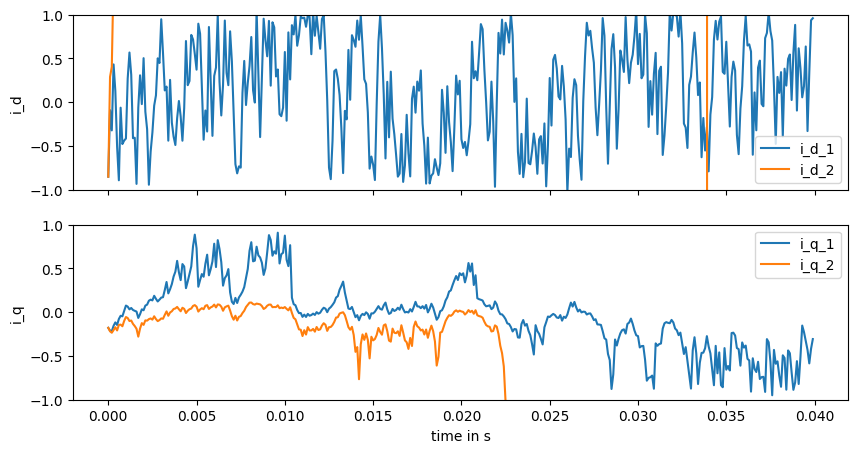

  8%|▊         | 1975/25000 [00:25<01:29, 258.32it/s]

Current val_loss: 38.130913


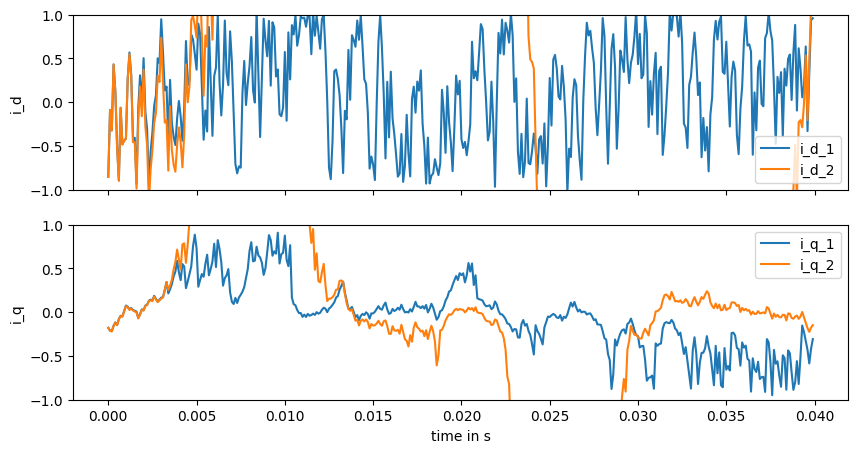

 16%|█▌        | 3984/25000 [00:34<01:23, 251.26it/s]

Current val_loss: 1.0689716


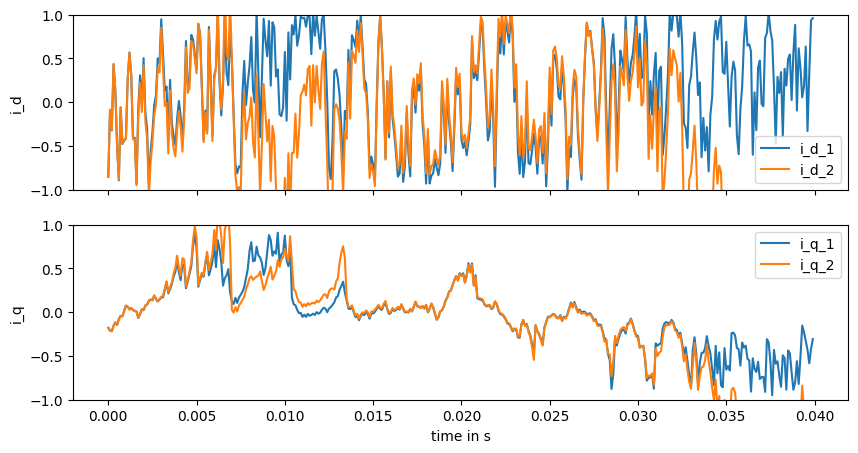

 24%|██▍       | 5994/25000 [00:43<01:28, 214.73it/s]

Current val_loss: 0.19929592


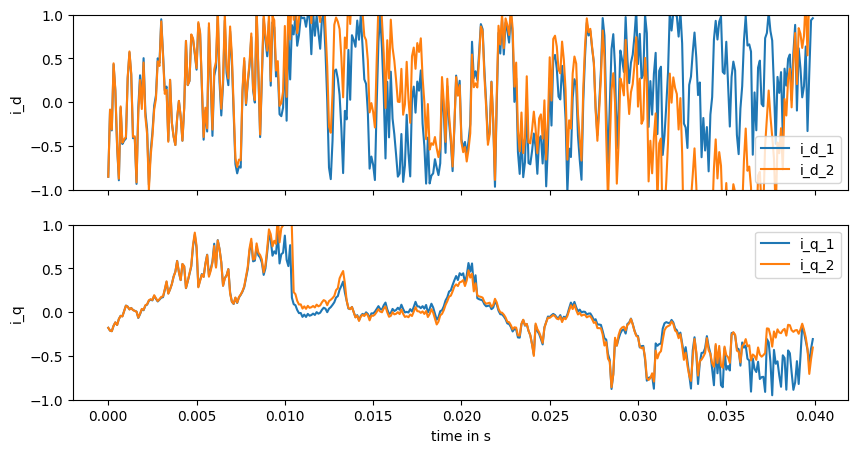

 32%|███▏      | 7988/25000 [00:52<01:06, 255.42it/s]

Current val_loss: 0.15449111


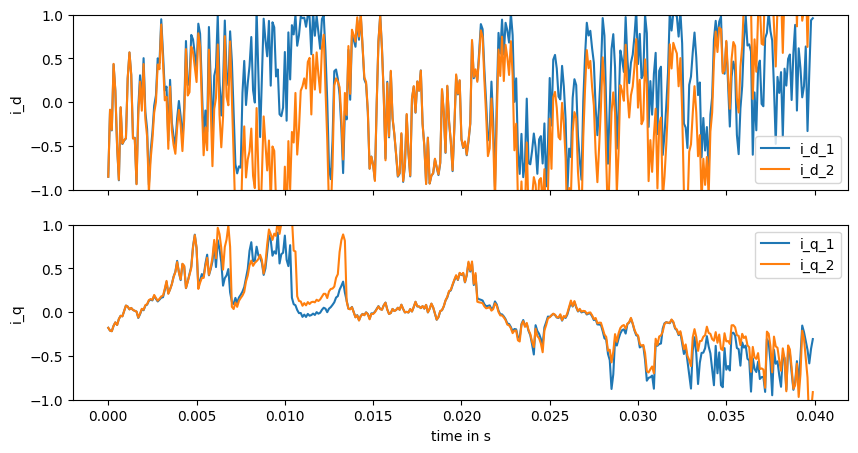

 40%|███▉      | 9990/25000 [01:01<00:58, 257.87it/s]

Current val_loss: 0.062134966


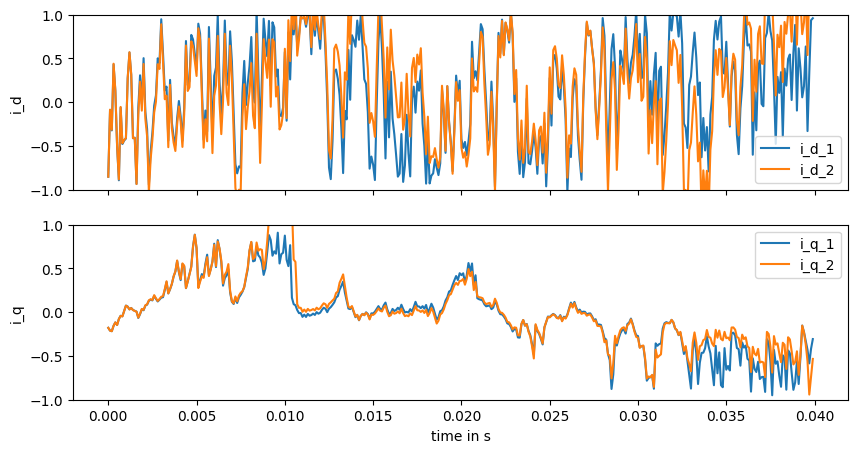

 48%|████▊     | 11992/25000 [01:10<00:50, 256.48it/s]

Current val_loss: 0.14898445


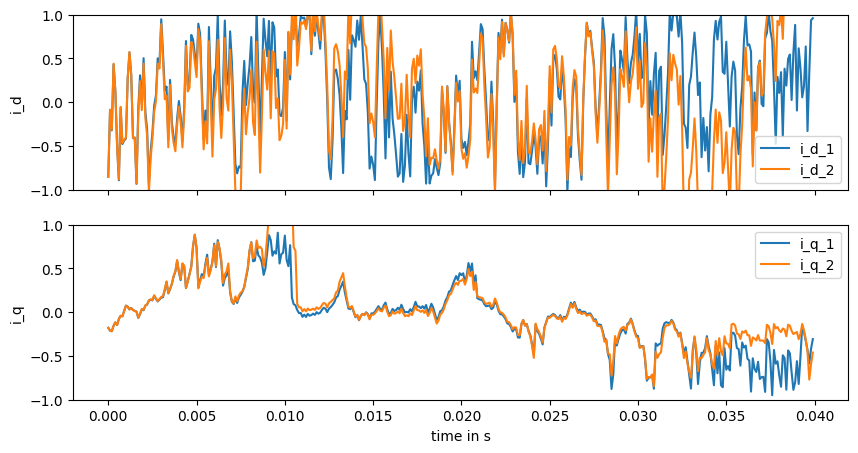

 56%|█████▌    | 13977/25000 [01:19<00:44, 249.07it/s]

Current val_loss: 0.12604497


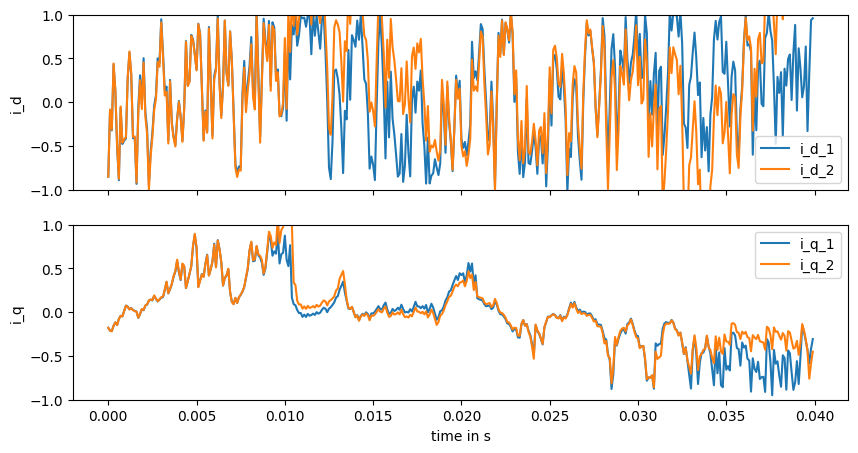

 64%|██████▍   | 15996/25000 [01:28<00:35, 254.69it/s]

Current val_loss: 0.17462327


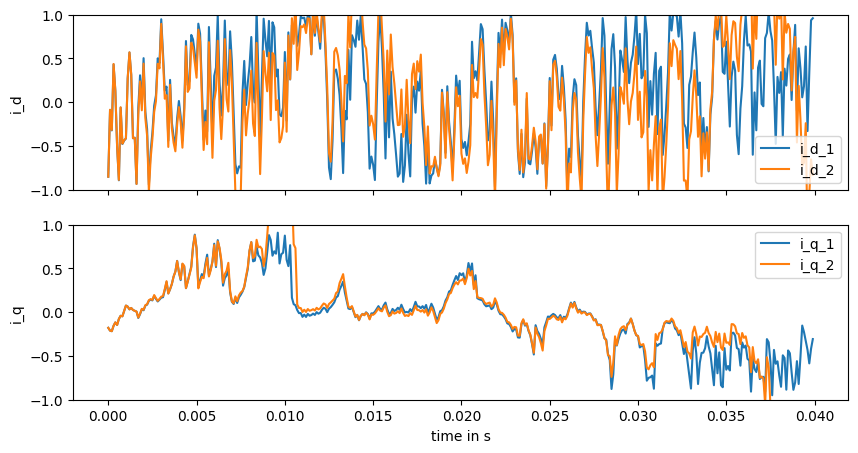

 72%|███████▏  | 17987/25000 [01:37<00:29, 239.96it/s]

Current val_loss: 0.70677966


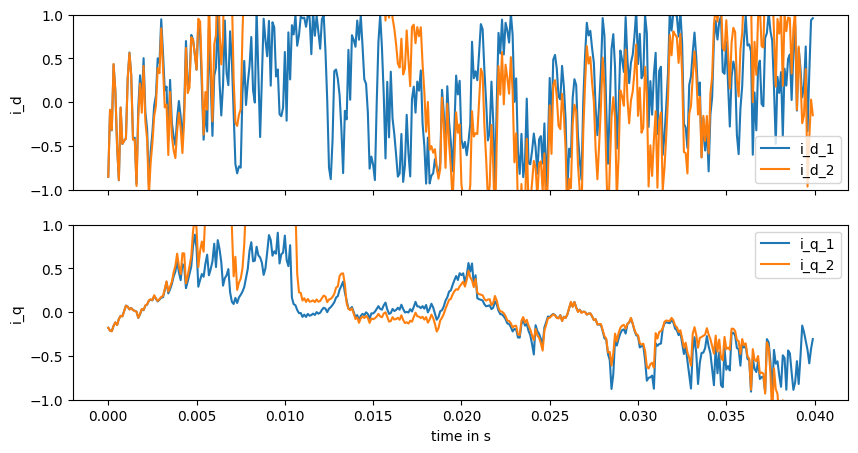

 80%|███████▉  | 19984/25000 [01:46<00:19, 257.84it/s]

Current val_loss: 0.6746511


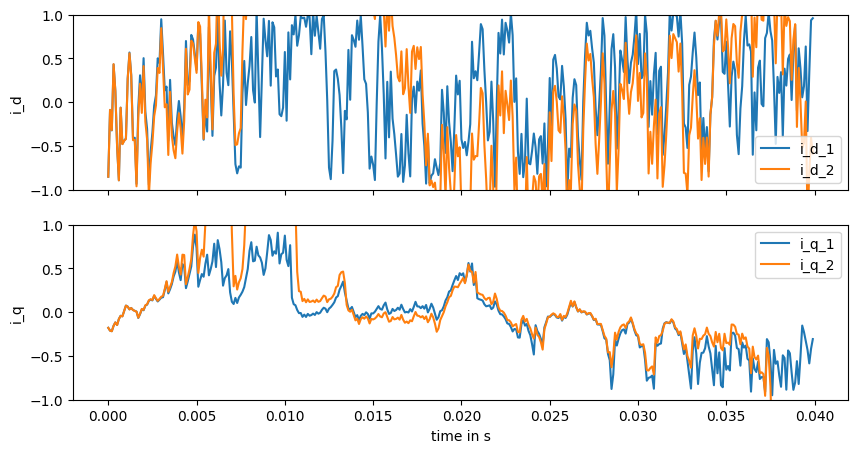

 88%|████████▊ | 21994/25000 [01:55<00:11, 260.17it/s]

Current val_loss: 12.782766


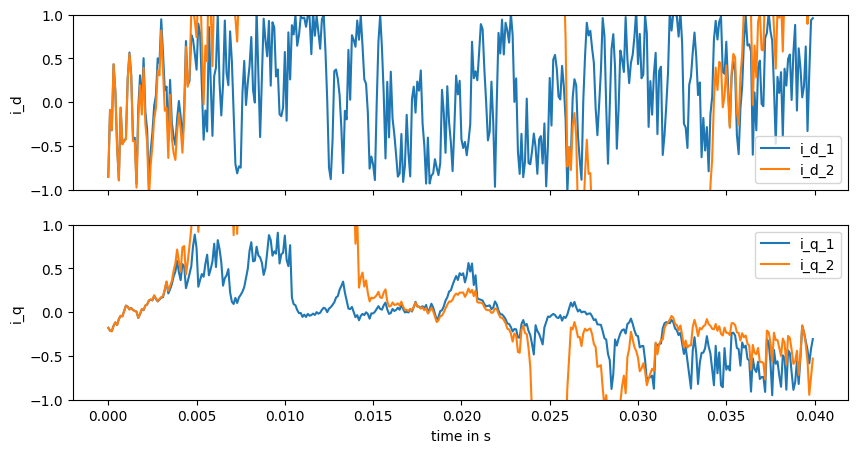

 96%|█████████▌| 23994/25000 [02:04<00:03, 258.35it/s]

Current val_loss: 0.19102548


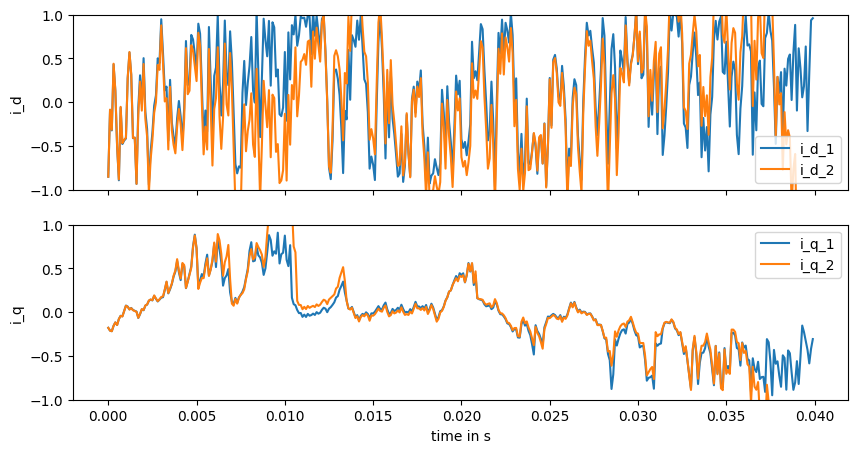

100%|██████████| 25000/25000 [02:09<00:00, 193.66it/s]


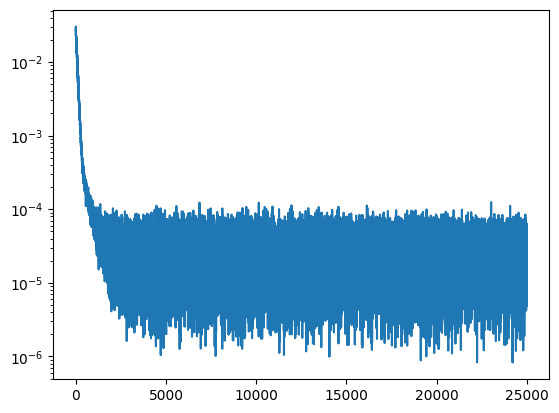

In [14]:
fin_node_1,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit_non_jit(node,opt_state,keys,plot_every=2000)
plt.plot(losses)
plt.yscale('log')

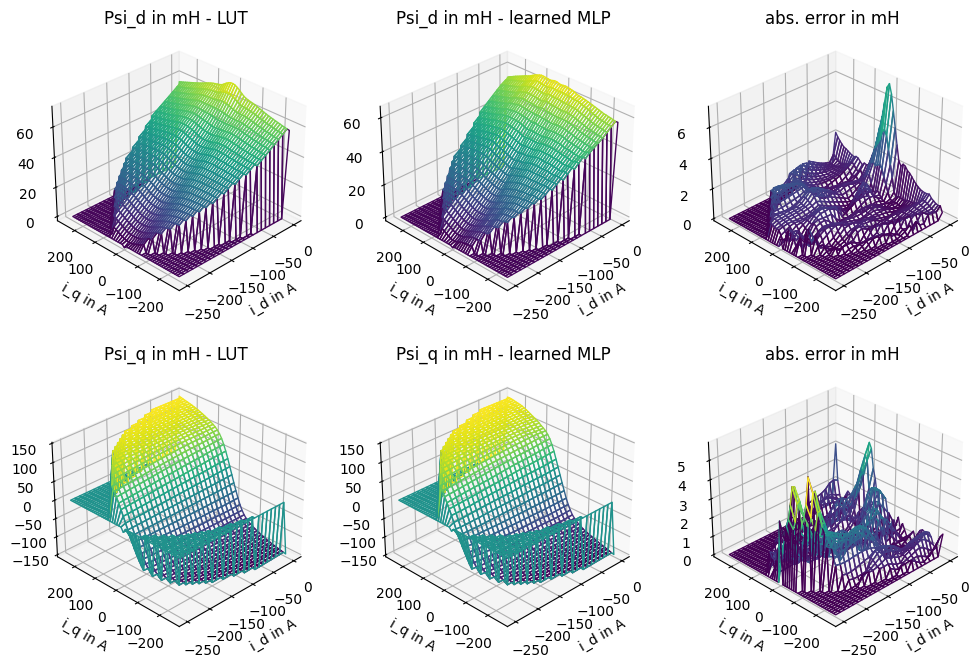

In [15]:
eval_psi(fin_node_1)

In [16]:
batch_size=100
mtrainer=ModelTrainer(
    train_steps=10_000,
    batch_size=batch_size,
    sequence_len=50,
    featurize=featurize_node,
    train_data_gen_sin=data_gen_single,
    val_data_gen_sin= val_data_gen_single,
    model_optimizer=optimizer_node,
    tau= 1e-4
    )
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))

  0%|          | 0/10000 [00:00<?, ?it/s]/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site

Current val_loss: 5409.7764


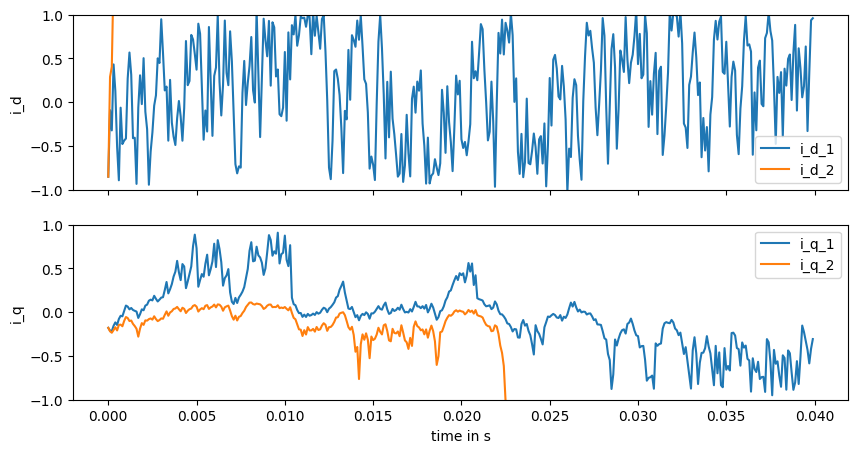

 10%|▉         | 999/10000 [01:17<10:10, 14.74it/s] 

Current val_loss: 0.11390144


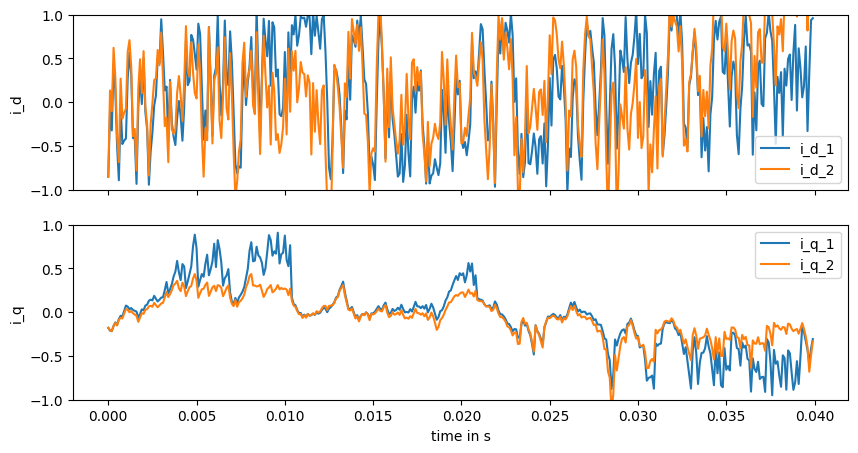

 20%|█▉        | 1999/10000 [02:25<08:58, 14.86it/s]

Current val_loss: 0.091643326


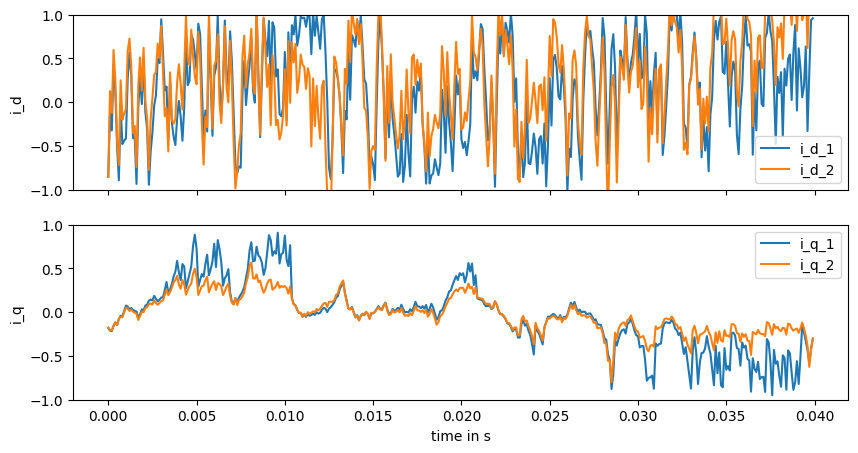

 30%|██▉       | 2999/10000 [03:33<07:43, 15.10it/s]

Current val_loss: 0.07411375


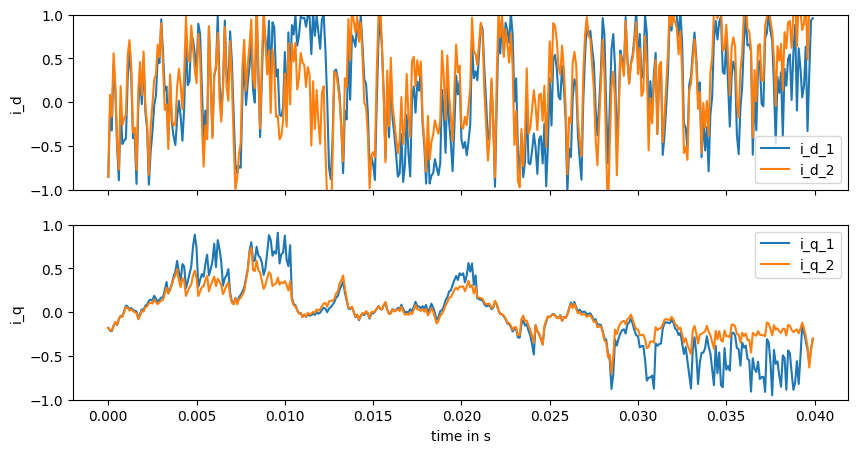

 40%|███▉      | 3999/10000 [04:41<06:43, 14.87it/s]

Current val_loss: 0.06416078


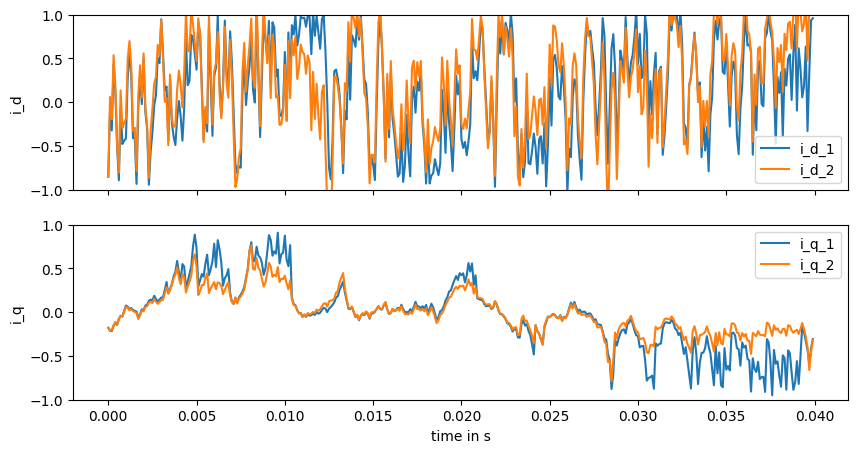

 50%|████▉     | 4999/10000 [05:49<05:32, 15.04it/s]

Current val_loss: 0.050555546


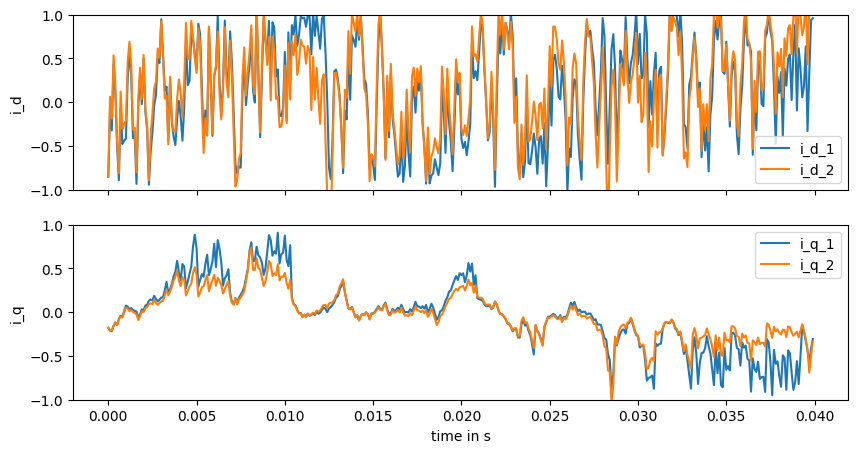

 60%|█████▉    | 5999/10000 [06:57<04:26, 15.03it/s]

Current val_loss: 0.037177417


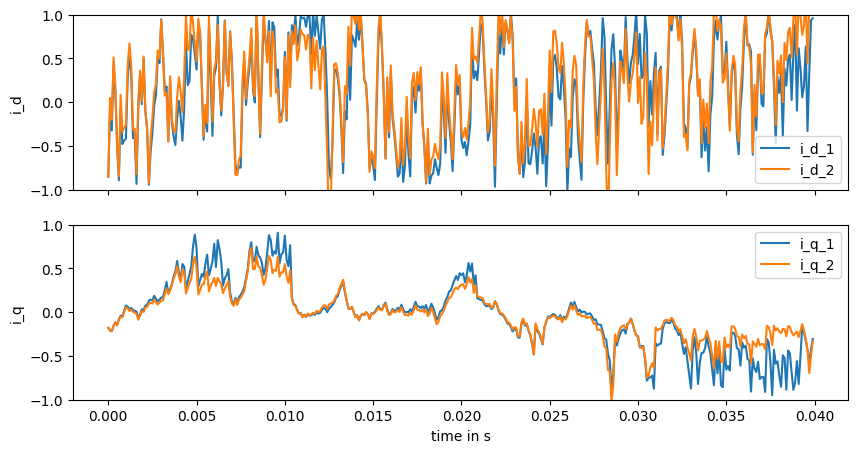

 70%|██████▉   | 6999/10000 [08:04<03:22, 14.84it/s]

Current val_loss: 0.035109106


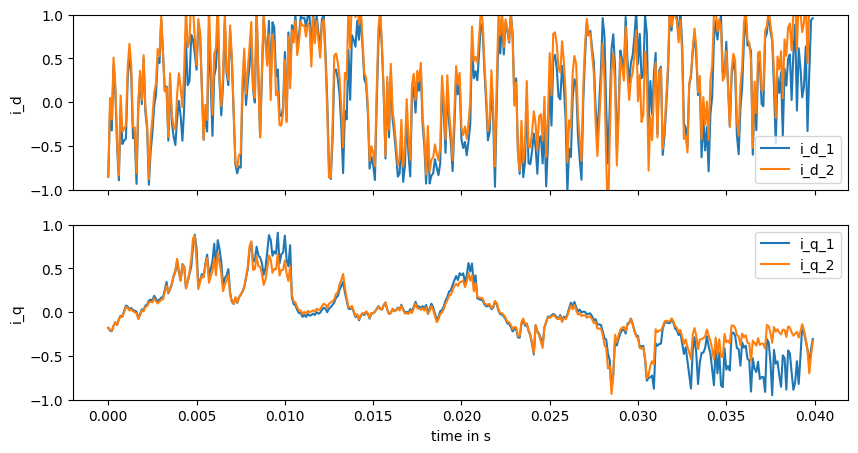

 80%|███████▉  | 7999/10000 [09:12<02:12, 15.16it/s]

Current val_loss: 0.032089274


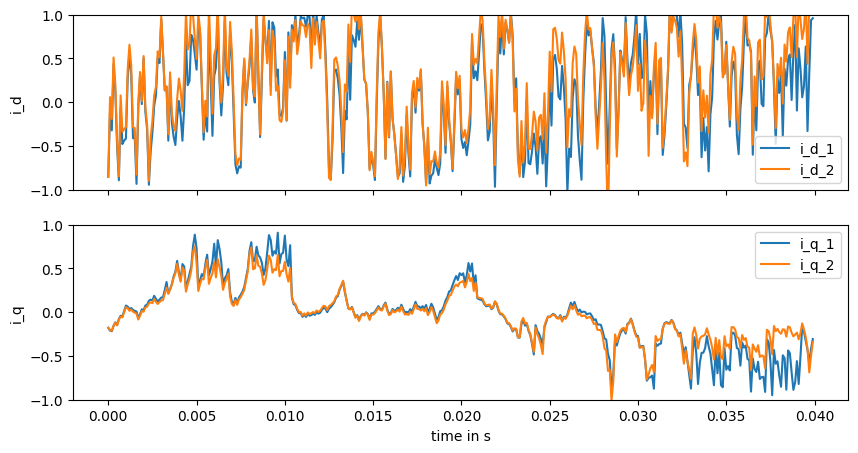

 90%|████████▉ | 8999/10000 [10:19<01:06, 15.11it/s]

Current val_loss: 0.02397165


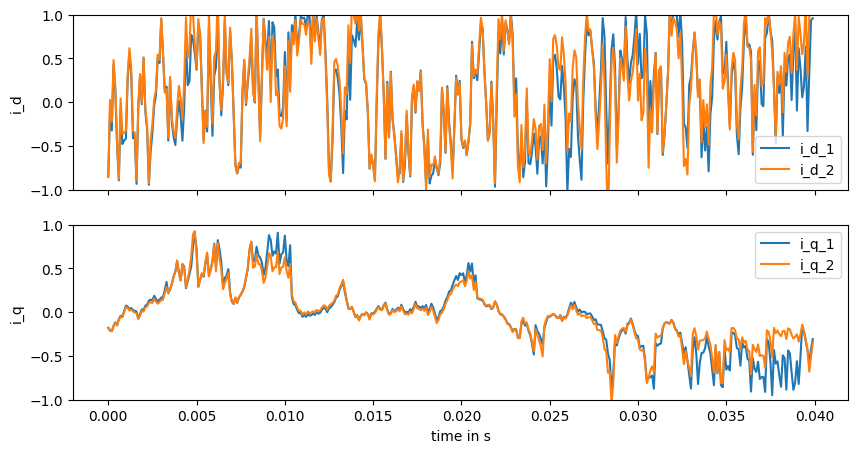

100%|██████████| 10000/10000 [11:27<00:00, 14.55it/s]


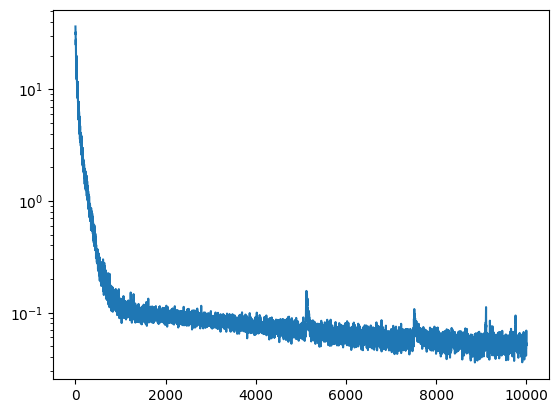

In [17]:
fin_node_50,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit_non_jit(node,opt_state,keys,plot_every=1000)
plt.plot(losses)
plt.yscale('log')

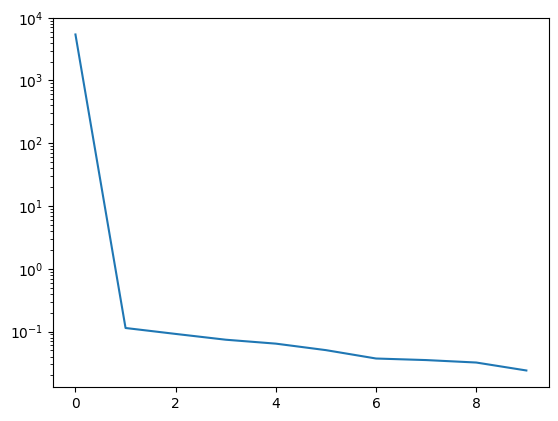

In [24]:
plt.plot(val_losses)
plt.yscale('log')

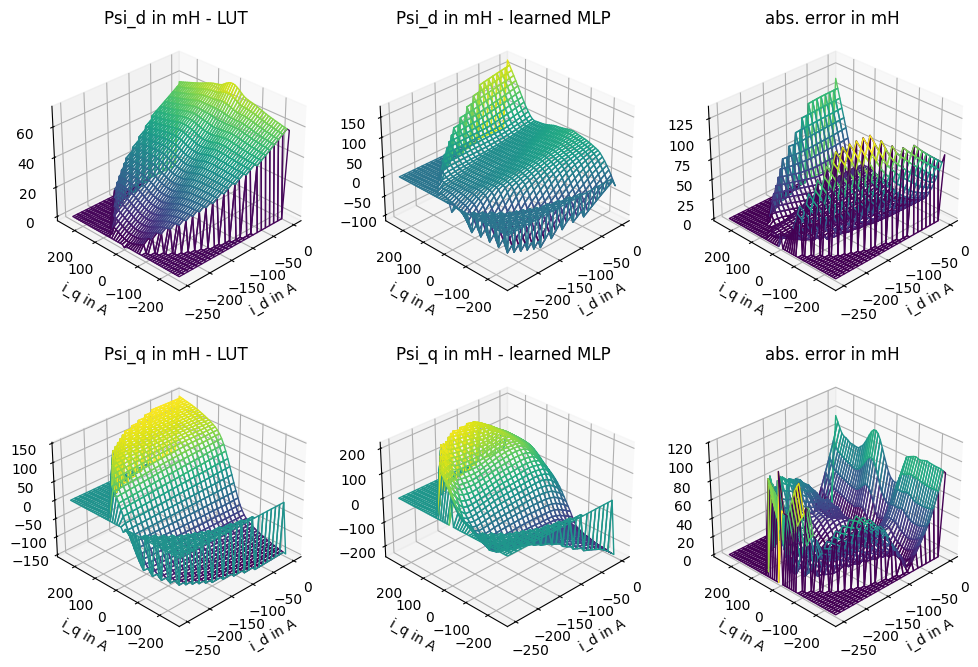

In [19]:
eval_psi(fin_node_50)

In [20]:
#eqx.tree_serialise_leaves("trained_models/Model_100k_100len_100b_step0_0001.eqx", fin_node_100)
#model_loaded = eqx.tree_deserialise_leaves("trained_models/Model1.eqx", node)

In [21]:
# @eqx.filter_jit
# def reset_env(env,rng):
#     obs, _ = env.reset(env.env_properties, rng)  #
#     obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
#     return obs

In [22]:
# from utils.evaluation import steps_eval_node

In [23]:
#_,_,_=steps_eval_node(motor_env,fin_node_1,motor_env.tau,reset_env,fin_policy2,featurize,featurize_node,jax.random.PRNGKey(4),2000)